In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn import linear_model

# Exploring BNP PCA analysis using smoothed and first derivative data

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

In [3]:
# read the total list of data files
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210604.csv')

# establish the file name for the first date
date='5/27/21'
bath_df = green_list_df.loc[green_list_df['date'] == date]
file_name = bath_df.iat[0, 0]
file = path_name + file_name

# since the wavelength vector does not change from session to session, here I get the first one.
calibration = bath_df['calibration'][120]
session = bath_df['session'][120]
cal_path = f'{session}/{calibration}'
vis_waves = get_visible_wavelength_vector(file, cal_path)

# this produces a list of strings of wavelength values
vis_columns = ["%.1f" % wave for wave in vis_waves]

# these are used to establish the first and last wavelengths that will be used in the analysis
vis_min_index = vis_columns.index('533.4')
vis_max_index = vis_columns.index('847.1')

vis_length = vis_max_index - vis_min_index

# here the actual data are read and compiled into a dataframe
all_absorbances = []
all_depths = []
df = pd.DataFrame()

dates = ['5/27/21', '6/4/21']

for date in dates: 
    bath_df = green_list_df.loc[green_list_df['date'] == date]
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name
    
    for index in bath_df.index.values:
        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        i_unique = bath_df['i_unique'][index]
        stop = date + " " + bath_df['target'][index][-3:]
        cal_path = f'{session}/{calibration}'
        insertion_path = f'{session}/{calibration}/{insertion}'
        vis_waves = get_visible_wavelength_vector(file, cal_path)[vis_min_index:vis_max_index]
        vis_columns = ["%.1f" % wave for wave in vis_waves]
        insertion_df = pd.DataFrame(get_visible_insertion_absorbances(file, insertion_path)[:, vis_min_index:vis_max_index], columns=vis_columns)
        insertion_df['depth'] = get_visible_insertion_spectrum_depths(file, insertion_path)
        insertion_df['session'] = session
        insertion_df['calibration'] = calibration
        insertion_df['insertion'] = insertion
        insertion_df['i_unique'] = i_unique
        insertion_df['stop'] = stop
        insertion_df['use'] = True
        df = pd.concat([df, insertion_df], ignore_index=True)

# this will be used to eliminate spectra that are invalid because they are from above the surface
df.loc[(df.depth < 5.0),'use'] = False

# this will be used to eliminate vegetation spectra
df.loc[(df['671.2']/df['735.7'] > 1.3), 'use'] = False

    
print(df.shape)

(1125, 248)


In [4]:
# these will be used as a surrogate for higher and lower SOC values.
# higher class numbers would be expected in general to have higher SOC content.

df['class'] = 1
df.loc[df['depth'] < 25, 'class'] = 2
df.loc[df['stop'] == '6/4/21 #10', 'class'] = 4
df.loc[df['stop'] == '6/4/21  #9', 'class'] = 4
df.loc[df['stop'] == '6/4/21  #8', 'class'] = 3
df.loc[df['stop'] == '5/27/21  #6', 'class'] = 3

In [5]:
# creates a dataframe containing only the "use" rows
df_use = df.loc[df['use']].copy()
print(df_use.shape)

(1006, 249)


# Smoothed data PCA

In [6]:
smoothed = savgol_filter(df_use.loc[:, vis_columns], 27, 1, axis=1)
smoothed_df = pd.DataFrame(smoothed, columns=vis_columns)

In [7]:
X = smoothed_df
pca = PCA(n_components=10)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

pc_labels = []
for i in range(10):    
    pc_label = f"PC{i + 1}"
    pc_labels.append(pc_label)
smoothed_pca_df = pd.DataFrame(X_pca, columns=pc_labels)

The smoothed data PCA is very similar (only smoother) to the PCA on the original dataset.

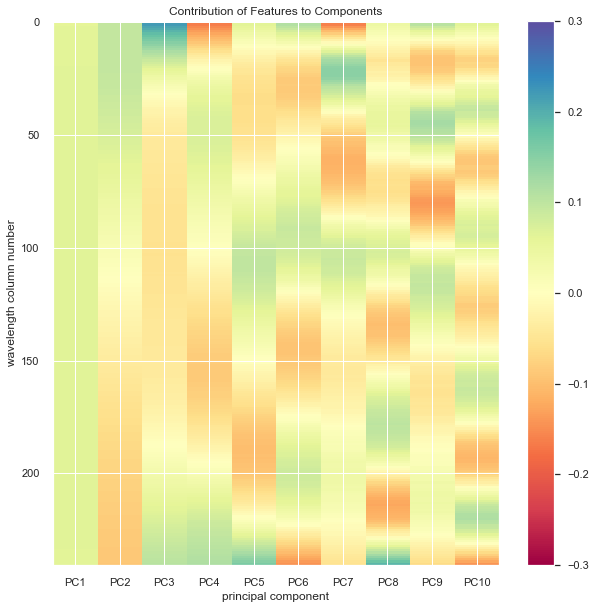

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
data = pca.components_[:10].T
plt.imshow(data, cmap="Spectral", vmin=-0.3, vmax=0.3, aspect='auto',
          interpolation='none')
ax.set_xticks(np.arange(data.shape[1]))
ax.set_xticklabels(pc_labels)
# plt.yticks(range(len(X.columns)), X.columns)
plt.title("Contribution of Features to Components")
plt.xlabel("principal component")
plt.ylabel("wavelength column number")
plt.colorbar()
plt.show()
plt.close()

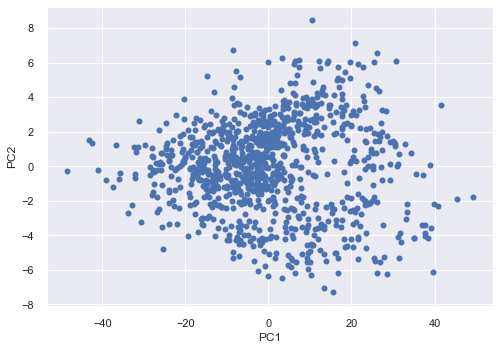

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.plot(smoothed_pca_df['PC1'], smoothed_pca_df['PC2'], 'o')
plt.show()
plt.close()

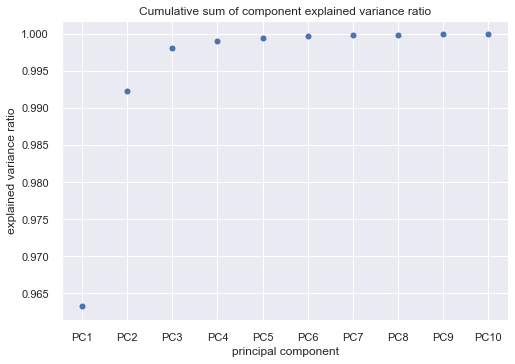

In [10]:
fig, ax = plt.subplots()
ax.set_title('Cumulative sum of component explained variance ratio')
ax.set_xlabel("principal component")
ax.set_ylabel("explained variance ratio")

ax.plot(pc_labels, np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.show()
plt.close()

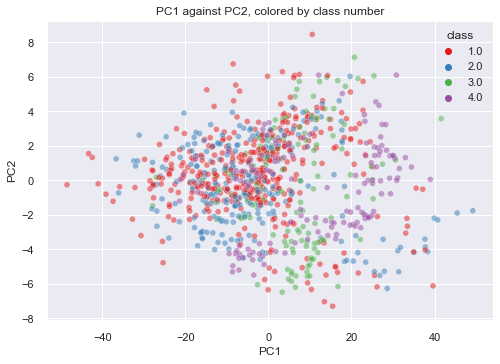

In [11]:
fig, ax = plt.subplots()
ax.set_title("PC1 against PC2, colored by class number")
sns.scatterplot(x=smoothed_pca_df['PC1'], y=smoothed_pca_df['PC2'], 
                hue=df_use['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

# First derivative data PCA

In [12]:
deriv = savgol_filter(smoothed, 27, 1, deriv=1, axis=1)
deriv_df = pd.DataFrame(deriv, columns=vis_columns)

In [13]:
X = deriv_df
pca = PCA(n_components=10)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

pc_labels = []
for i in range(10):    
    pc_label = f"PC{i + 1}"
    pc_labels.append(pc_label)
deriv_pca_df = pd.DataFrame(X_pca, columns=pc_labels)

The derivative data PCA is quite different from the original PCA.

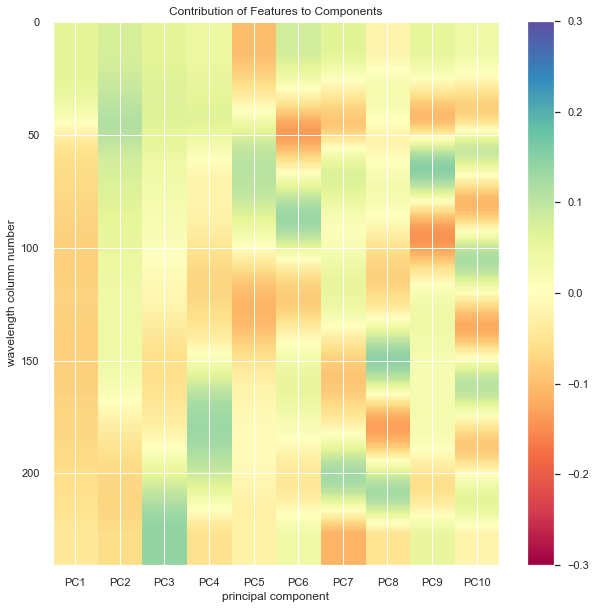

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
data = pca.components_[:10].T
plt.imshow(data, cmap="Spectral", vmin=-0.3, vmax=0.3, aspect='auto',
          interpolation='none')
ax.set_xticks(np.arange(data.shape[1]))
ax.set_xticklabels(pc_labels)
# plt.yticks(range(len(X.columns)), X.columns)
plt.title("Contribution of Features to Components")
plt.xlabel("principal component")
plt.ylabel("wavelength column number")
plt.colorbar()
plt.show()
plt.close()

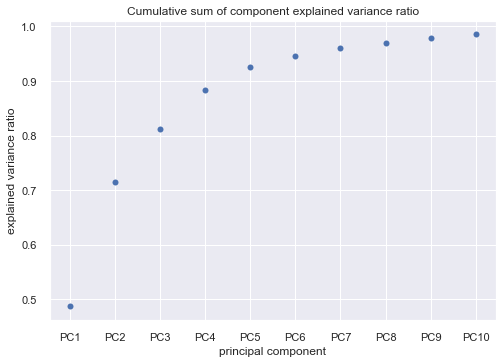

In [15]:
fig, ax = plt.subplots()
ax.set_title('Cumulative sum of component explained variance ratio')
ax.set_xlabel("principal component")
ax.set_ylabel("explained variance ratio")

ax.plot(pc_labels, np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.show()
plt.close()

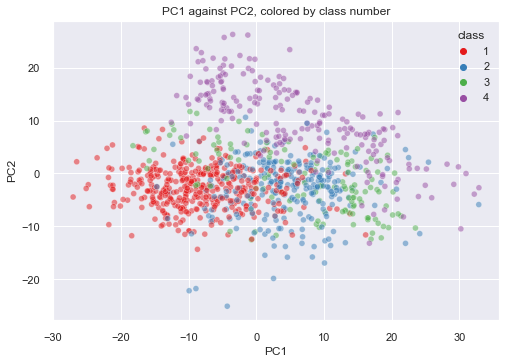

In [16]:
fig, ax = plt.subplots()
df_info = df_use.iloc[:, -8:].copy().reset_index()
ax.set_title("PC1 against PC2, colored by class number")
sns.scatterplot(x=deriv_pca_df['PC1'], y=deriv_pca_df['PC2'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

### This contains code for creating an interactive 3D graph

%matplotlib qt

df_info = df_use.iloc[:, -8:].copy().reset_index()

ax = plt.axes(projection='3d')
class_1 = deriv_pca_df.loc[df_info['class'] == 1]
xdata = class_1['PC1']
ydata = class_1['PC2']
zdata = class_1['PC3']
ax.scatter3D(xdata, ydata, zdata, color = 'b')

class_2 = deriv_pca_df.loc[df_info['class'] == 2]
xdata2 = class_2['PC1']
ydata2 = class_2['PC2']
zdata2 = class_2['PC3']
ax.scatter3D(xdata2, ydata2, zdata2, color = 'c')

class_3 = deriv_pca_df.loc[df_info['class'] == 3]
xdata3 = class_3['PC1']
ydata3 = class_3['PC2']
zdata3 = class_3['PC3']
ax.scatter3D(xdata3, ydata3, zdata3, color = 'g')

class_4 = deriv_pca_df.loc[df_info['class'] == 4]
xdata4 = class_4['PC1']
ydata4 = class_4['PC2']
zdata4 = class_4['PC3']
ax.scatter3D(xdata4, ydata4, zdata4, color = 'r')

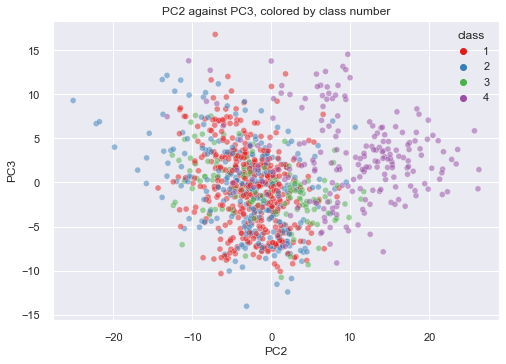

In [17]:
fig, ax = plt.subplots()
ax.set_title("PC2 against PC3, colored by class number")
sns.scatterplot(x=deriv_pca_df['PC2'], y=deriv_pca_df['PC3'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

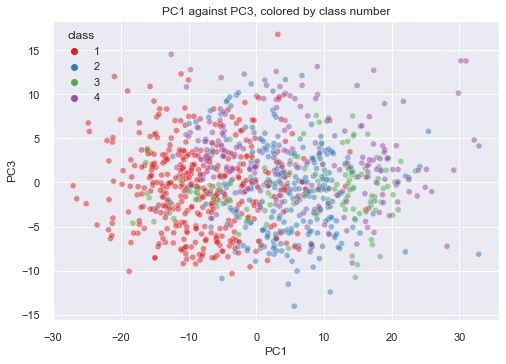

In [18]:
fig, ax = plt.subplots()
ax.set_title("PC1 against PC3, colored by class number")
sns.scatterplot(x=deriv_pca_df['PC1'], y=deriv_pca_df['PC3'], 
                hue=df_info['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

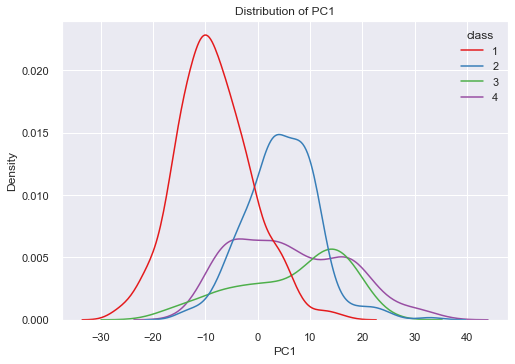

In [19]:
fig, ax = plt.subplots()
ax.set_title("Distribution of PC1")
sns.kdeplot(x=deriv_pca_df['PC1'], hue=df_info['class'], palette='Set1')
plt.show()
plt.close()

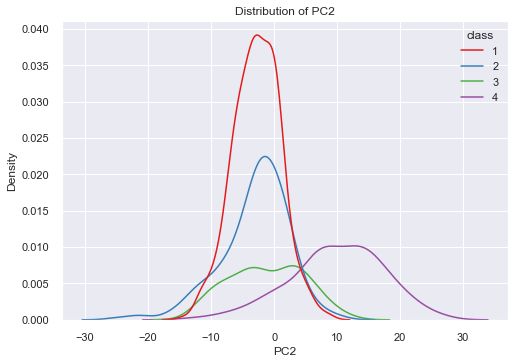

In [20]:
fig, ax = plt.subplots()
ax.set_title("Distribution of PC2")
sns.kdeplot(x=deriv_pca_df['PC2'], hue=df_info['class'], palette='Set1')
plt.show()
plt.close()

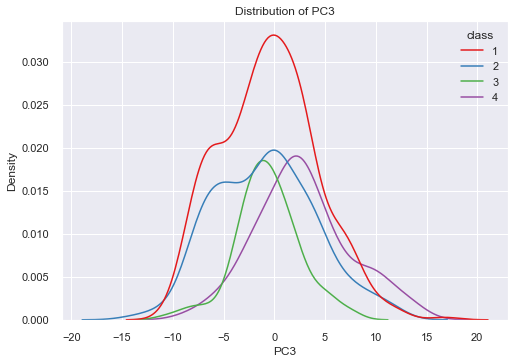

In [21]:
fig, ax = plt.subplots()
ax.set_title("Distribution of PC3")
sns.kdeplot(x=deriv_pca_df['PC3'], hue=df_info['class'], palette='Set1')
plt.show()
plt.close()